In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Overview

Creating artificial images is an exciting and challenging endeavor in the machine learning community. This competition is designed to provide new data scientists with the opportunity to practice and learn how to generate artificial images using Generative Adversarial Network (GAN) models. This notebook serves as a platform for honing essential skills and gaining a deeper understanding of how GANs function, using a dataset consisting of real images of dogs. In essence, this competition involves the orchestration of two neural networks: a generator, responsible for producing fake images, and a discriminator, tasked with distinguishing between real and fake images. As the generator undergoes training, its ability to generate increasingly convincing images improves, with the ultimate objective of deceiving the discriminator into accepting its fake images as real. The overarching goal is to generate images that are so realistic that even the discriminator is unable to differentiate them from authentic ones.

The structure of this notebook is organized into the following sections:

1. **Description of the Problem and Data**: This section will provide an introduction to the problem statement and an overview of the dataset containing images of dogs that will be used for training and evaluation.

2. **Exploratory Data Analysis (EDA)**: In this section, we will explore the dataset to gain insights into its characteristics. This may involve visualizing sample images, examining data distributions, and identifying any potential challenges or patterns.

3. **Analysis - Model Building and Training**: The heart of the notebook, this section delves into the development and training of GAN models. It will cover the architecture of both the generator and discriminator networks, as well as the training process. Various techniques and strategies to enhance GAN performance may be discussed.

4. **Results**: Here, we will showcase the generated images produced by the trained GAN and evaluate their quality. Metrics and visual comparisons may be used to assess the effectiveness of the model in generating realistic images.

5. **Conclusion**: The final section wraps up the notebook by summarizing the key findings, discussing any challenges faced during the project, and reflecting on the broader implications of using GANs for image generation. Future directions and potential improvements may also be considered.

In essence, this notebook serves as a comprehensive guide for data scientists and machine learning enthusiasts to embark on their journey of creating artificial images using GANs, all while leveraging the power of real data and cutting-edge techniques in the fascinating world of generative adversarial networks.

In [1]:
#import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, zipfile
import seaborn as sns
import cv2
import random
import os
import xml.etree.ElementTree as ET 
import PIL
from PIL import Image
import time
import shutil
from IPython import display
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = tf.random.set_seed(49)

### 1. Description of the problem and data
The goal of this competition is to be able to confuse the computer into thinking our generated images are real. We are given two zipped folders, 'Annotation' and 'all-dogs'. Annotation contains the class labels and bounding boxes for the images. All-dogs contains the images. Images are initially different sizes. We are not given a dataframe to view or plot values. Instead, we will move on to the EDA and view some images. Prior to training, we will set our training data (images) as "train_images" and we will normalize all images.

In [3]:
#get filenames
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/generative-dog-images/Annotation.zip
/kaggle/input/generative-dog-images/all-dogs.zip


In [4]:
#set directory and unzip folders
if not os.path.exists('generative-dog-images'):
    !mkdir /kaggle/working/generative-dog-images
!unzip /kaggle/input/generative-dog-images/all-dogs.zip -d /kaggle/working/generative-dog-images > /dev/null 2>&1
!unzip /kaggle/input/generative-dog-images/Annotation.zip -d /kaggle/working/generative-dog-images > /dev/null 2>&1

In [5]:
#set directories and paths
all_dogs_dir = '/kaggle/working/generative-dog-images/all-dogs/'
annotation_dir = '/kaggle/working/generative-dog-images/Annotation/'

IMAGES = os.listdir(all_dogs_dir)
BREEDS = os.listdir(annotation_dir)

In [6]:
# Setup GPU accelerator - configure Strategy. Assume TPU...if not set default for GPU/CPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [7]:
print('Dog Count:', len(os.listdir(all_dogs_dir)))
print('Breed Count:', len(os.listdir(annotation_dir)))

Dog Count: 20579
Breed Count: 120


### 2. Exploratory data analysis (EDA)


We will crop the images to the bounding boxes and save them. Each image prior to crop and after will be a different size based on the bounding box and original image size. Then we will resize the images to be 100x100 pixels with 3 color channels. After cropping the images, we visualize them below.

In [9]:
# Crop to bounding boxes such that we only have the dog(s) in the picture
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
idxIn = 0
namesIn = []
imagesIn = np.zeros((25000,100,100,3))

for breed in BREEDS: 
    for dog in os.listdir(annotation_dir+breed):
        try: img = Image.open(all_dogs_dir+dog+'.jpg') #open image
        except: continue           
        tree = ET.parse(annotation_dir+breed+'/'+dog)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects: #bounding box
            bndbox = o.find('bndbox') 
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w)) #crop to bounding box
            img2 = img2.resize((100,100), Image.ANTIALIAS) #resize to 100x100
            imagesIn[idxIn,:,:,:] = np.asarray(img2)
            namesIn.append(breed)
            idxIn += 1
idx = np.arange(idxIn)
np.random.shuffle(idx)
imagesIn = imagesIn[idx,:,:,:]
namesIn = np.array(namesIn)[idx]

/tmp/ipykernel_32/2288927954.py:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img2 = img2.resize((100,100), Image.ANTIALIAS) #resize to 100x100


In [10]:
#delete files now that we have images 
# and names files to make room
shutil.rmtree(all_dogs_dir)
shutil.rmtree(annotation_dir)

In [11]:
imagesIn.shape


(22125, 100, 100, 3)

In [12]:
namesIn.shape


(22125,)

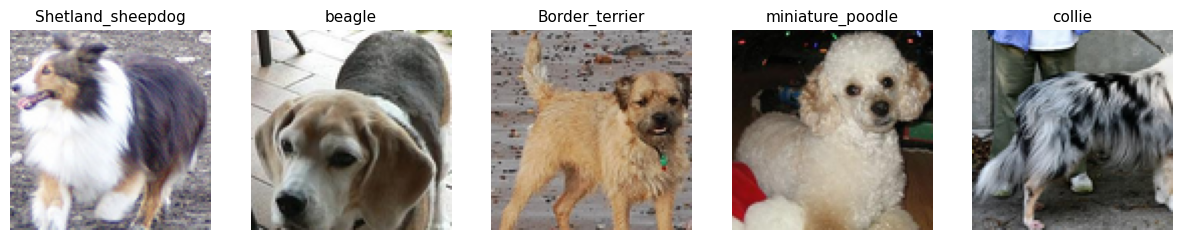

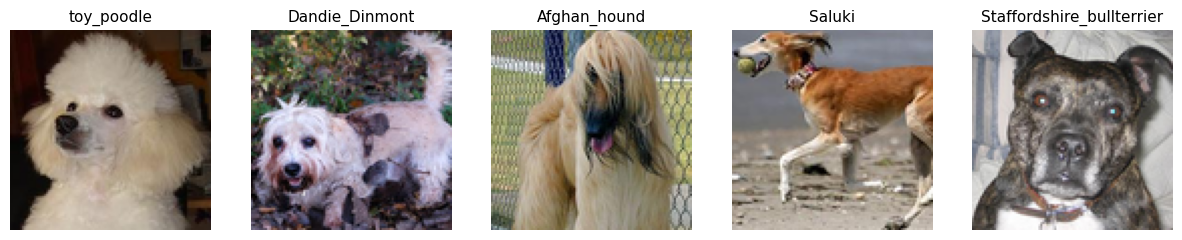

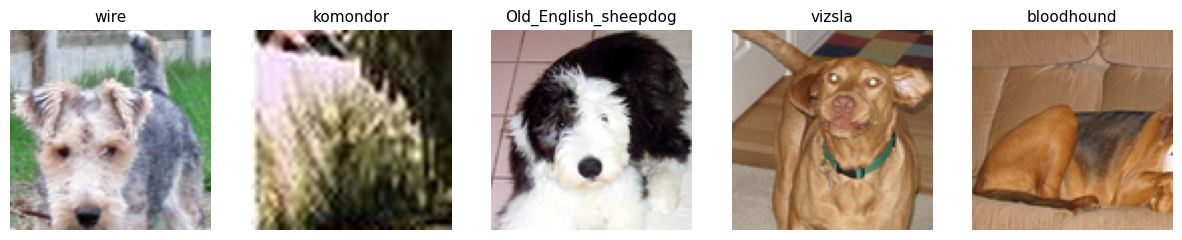

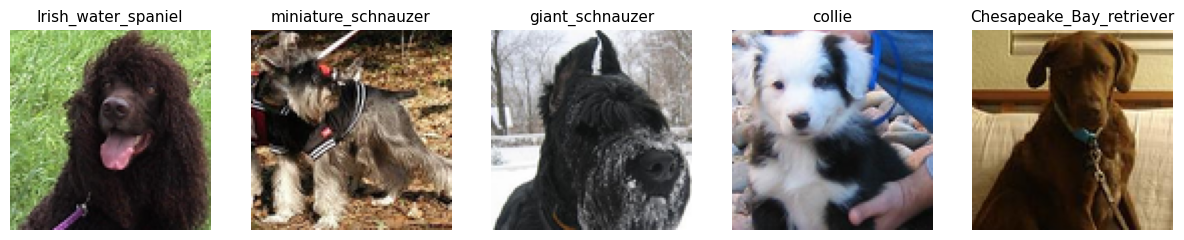

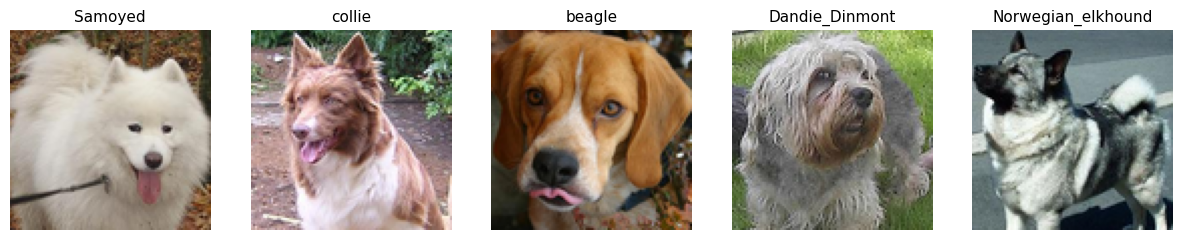

In [13]:
# visualize cropped images
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray(imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show();

In [14]:
# normalize to [-1, 1]
train_images = imagesIn / 127.5 - 127.5
del imagesIn  
train_images.shape

(22125, 100, 100, 3)

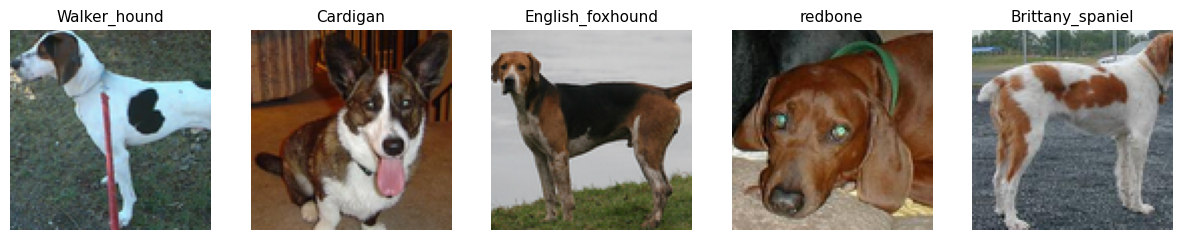

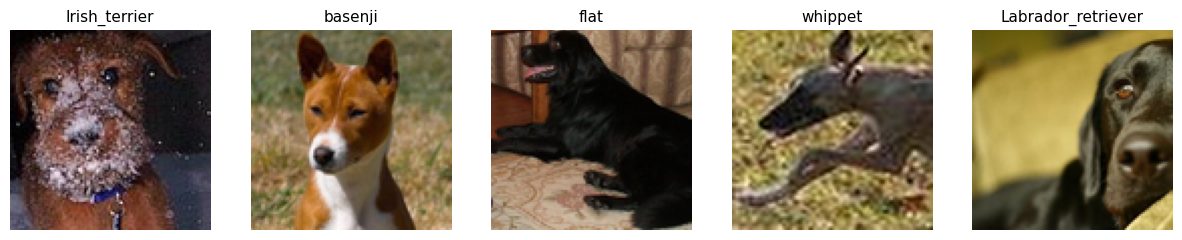

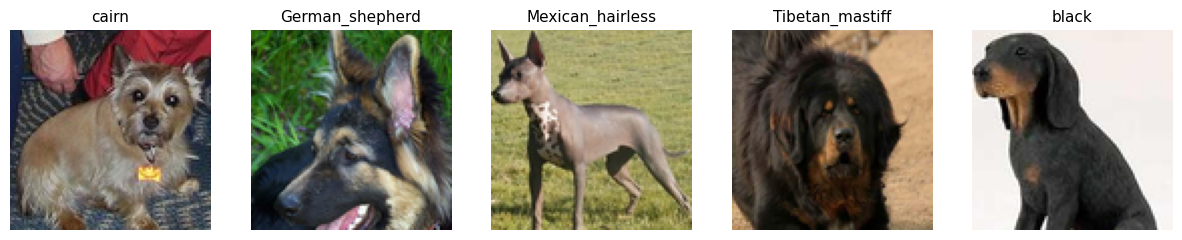

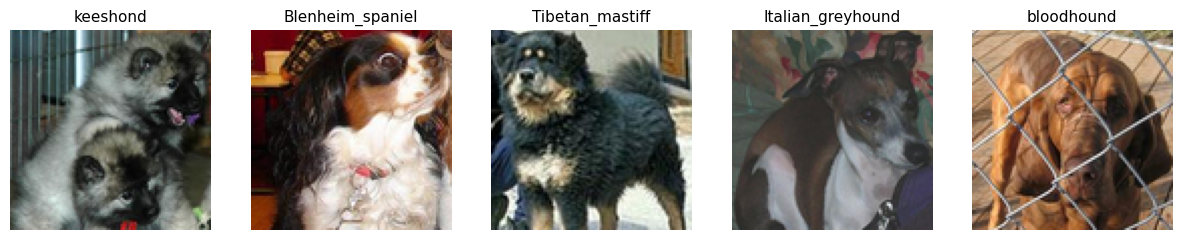

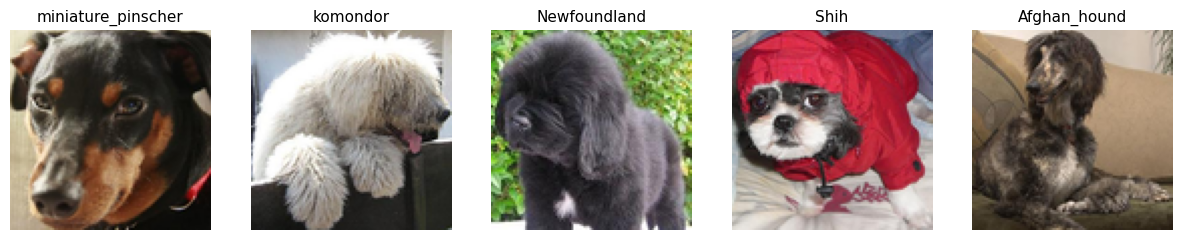

In [15]:
# Make sure we can return to 'normal' color fotos after having normalized
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray((train_images[x[k*5+j],:,:,:]*127.5 +127.5).astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show();

### 3. Analysis - model building and training
Now for the fun part! We will begin to train our GAN model. We have cropped and normalized our data above, which is what we will use in the model. We will declare two models: generator and discriminator. The generator will create images and try to "trick" the discriminator. The discriminator will decide which images are real or fake. Our goal is to fool the discriminator such that it thinks our generated images are actually real. We will use 200 epochs, which we hope will be enough to train the models. Next, we will create 16 images per epoch so that we can see what the generator is creating. Our generator will have multiple layers using activation functions such as ReLU and Leaky ReLU. Leaky ReLU will help the function from becoming saturated at 0.

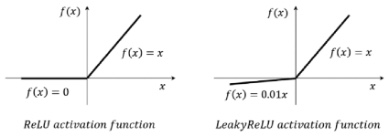

We will also use dropout layers which randomly sets input units to 0 during each training step. We will use batch normalization which normalizes its inputs by keeping the mean close to 0. In the generator model, we will use 3 as our output so that we have 3 color channels, and we will use a 'tanh' activation function which gives higher gradient values during training and more weight changes in network. In the discriminator, we will use 1 so that we have a yes/no type of response (is or isn't real), and we will use a linear activation function. As suggested by other Kagglers. For our loss functions, we will use Binary Cross Entropy. When compiling the models, we will use the Adam optimizer with a learning rate of 0.0001.

In [16]:
# set globals for training
EPOCHS = 100 
NOISE_DIM = 100
BATCH_SIZE = 256
LATENT_DIM = 100*100*3 
ONES = np.ones(BATCH_SIZE)
ZEROS = np.zeros(BATCH_SIZE)

In [17]:
#reshape images for model
train_images = train_images.reshape(-1, 100*100*3)
train_images.shape

(22125, 30000)

In [18]:
#build generator model
def create_generator(latentDim):
    with strategy.scope():

        inputs = Input(shape=(latentDim, ))
        gen = layers.Dense(256, activation=LeakyReLU(alpha=0.2))(inputs) 
        gen = layers.BatchNormalization(momentum=0.8)(gen) 
        gen = layers.Dense(512, activation=LeakyReLU(alpha=0.2))(gen)
        gen = layers.BatchNormalization(momentum=0.8)(gen)
        gen = layers.Dense(1024, activation=LeakyReLU(alpha=0.2))(gen)
        gen = layers.BatchNormalization(momentum=0.8)(gen)
        gen = Dense(100*100*3, activation='tanh')(gen)
        model = Model(inputs, gen)
        return model

In [19]:
#build discriminator model
def create_discriminator(image_size):
    with strategy.scope():

        inputs = Input(shape=(image_size, ))
        disc = layers.Dense(512, activation=LeakyReLU(alpha=0.2))(inputs)
        disc = layers.Dense(256, activation=LeakyReLU(alpha=0.2))(disc)
        disc = layers.Dense(1, activation='sigmoid')(disc)
        model = Model(inputs, disc)
        return model

In [20]:
with strategy.scope():

    #build discriminator 
    discriminator = create_discriminator(100*100*3) 
    discriminator.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                          optimizer=tf.keras.optimizers.Adam(0.0001), 
                          metrics=['accuracy'])

In [21]:
#build combined model
generator = create_generator(LATENT_DIM)

In [22]:
print(' ############## GENERATOR MODEL ##############')
generator.summary()
print('\n', '############## DISCRIMINATOR MODEL ##############')
discriminator.summary()

 ############## GENERATOR MODEL ##############
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_3 (Dense)             (None, 256)               7680256   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_5 (De

Prediction =  tf.Tensor([[0.49580717]], shape=(1, 1), dtype=float32)


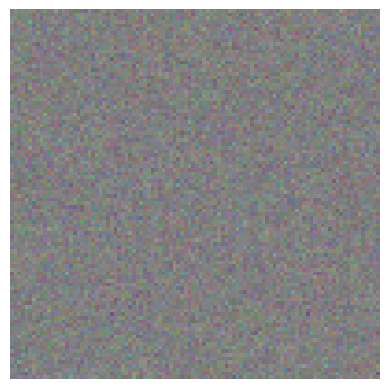

In [23]:
#visualize example and make sure its working correct
noise = tf.random.normal([1, LATENT_DIM])
image = generator(noise)
discriminator.trainable = False
prediction = discriminator(image)
image = (tf.reshape(image, (100,100,3)).numpy()* 127.5 + 127.5).astype(int) 
plt.imshow(image);
plt.axis('off')
print("Prediction = ", prediction)

In [24]:
with strategy.scope():

    #compile model completely using noise image as our starting point
    noise = Input(shape=(LATENT_DIM, ))
    image = generator(noise)
    prediction = discriminator(image)

    GAN = Model(noise, prediction) 

    GAN.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                          optimizer=tf.keras.optimizers.Adam(0.0001))

In [25]:
#create folder to save generator images
if not os.path.exists('GAN_images'):
    os.makedirs('GAN_images')

In [26]:
#produce sample images
def sample_images(epoch):
    rows = 5
    cols = 5
    noise = np.random.randn(rows*cols, LATENT_DIM)
    images = generator.predict(noise)
    images = (tf.reshape(images, (images.shape[0], 100,100,3)).numpy()* 127.5 + 127.5).astype(int) 
    fig, axs = plt.subplots(rows, cols)
    index = 0
    for r in range(rows):
        for c in range(cols): 
            axs[r,c].imshow(images[index])
            axs[r,c].axis('off')
            index+=1
    plt.show()
    fig.savefig('GAN_images/%d.png' % epoch) 
    plt.close()

8/8 [==============================] - 1s 40ms/step
epoch: 1/100, disc_loss: 0.3223, gen_loss: 0.7741
Fake Images at Epoch: 1/100
1/1 [==============================] - 0s 143ms/step


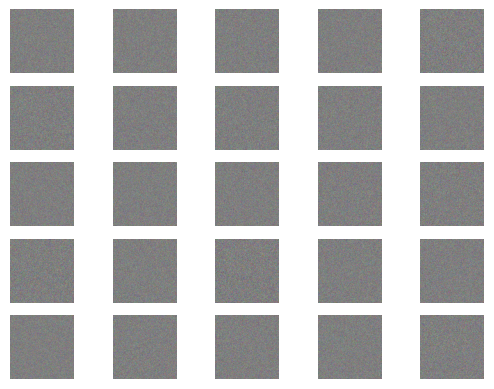

8/8 [==============================] - 0s 38ms/step
epoch: 2/100, disc_loss: 0.2039, gen_loss: 0.7671
8/8 [==============================] - 0s 38ms/step
epoch: 3/100, disc_loss: 0.2042, gen_loss: 0.7298
8/8 [==============================] - 0s 39ms/step
epoch: 4/100, disc_loss: 0.2189, gen_loss: 0.6498
8/8 [==============================] - 0s 47ms/step
epoch: 5/100, disc_loss: 0.2437, gen_loss: 0.5779
8/8 [==============================] - 0s 39ms/step
epoch: 6/100, disc_loss: 0.2299, gen_loss: 0.4959
8/8 [==============================] - 0s 37ms/step
epoch: 7/100, disc_loss: 0.2189, gen_loss: 0.4268
8/8 [==============================] - 0s 39ms/step
epoch: 8/100, disc_loss: 0.1907, gen_loss: 0.3791
8/8 [==============================] - 0s 38ms/step
epoch: 9/100, disc_loss: 0.1738, gen_loss: 0.3223
8/8 [==============================] - 0s 37ms/step
epoch: 10/100, disc_loss: 0.1576, gen_loss: 0.3027
8/8 [==============================] - 0s 38ms/step
epoch: 11/100, disc_loss: 0.1

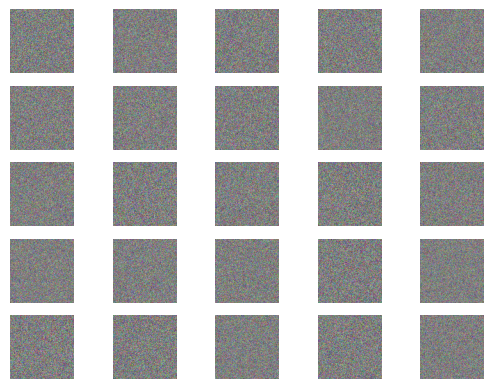

8/8 [==============================] - 0s 37ms/step
epoch: 12/100, disc_loss: 0.1295, gen_loss: 0.2621
8/8 [==============================] - 0s 60ms/step
epoch: 13/100, disc_loss: 0.1282, gen_loss: 0.2562
8/8 [==============================] - 0s 39ms/step
epoch: 14/100, disc_loss: 0.1222, gen_loss: 0.2498
8/8 [==============================] - 0s 38ms/step
epoch: 15/100, disc_loss: 0.1160, gen_loss: 0.2478
8/8 [==============================] - 0s 37ms/step
epoch: 16/100, disc_loss: 0.1177, gen_loss: 0.2477
8/8 [==============================] - 0s 39ms/step
epoch: 17/100, disc_loss: 0.1219, gen_loss: 0.2419
8/8 [==============================] - 0s 40ms/step
epoch: 18/100, disc_loss: 0.1168, gen_loss: 0.2414
8/8 [==============================] - 0s 38ms/step
epoch: 19/100, disc_loss: 0.1167, gen_loss: 0.2362
8/8 [==============================] - 0s 37ms/step
epoch: 20/100, disc_loss: 0.1145, gen_loss: 0.2396
8/8 [==============================] - 0s 49ms/step
epoch: 21/100, disc_l

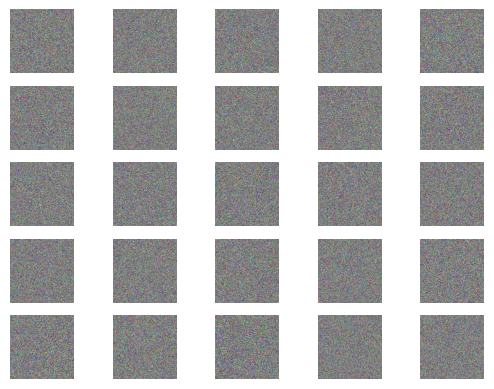

8/8 [==============================] - 0s 37ms/step
epoch: 22/100, disc_loss: 0.1152, gen_loss: 0.2246
8/8 [==============================] - 0s 39ms/step
epoch: 23/100, disc_loss: 0.1101, gen_loss: 0.2194
8/8 [==============================] - 0s 37ms/step
epoch: 24/100, disc_loss: 0.1102, gen_loss: 0.2132
8/8 [==============================] - 0s 37ms/step
epoch: 25/100, disc_loss: 0.1005, gen_loss: 0.2061
8/8 [==============================] - 0s 38ms/step
epoch: 26/100, disc_loss: 0.1013, gen_loss: 0.2031
8/8 [==============================] - 0s 38ms/step
epoch: 27/100, disc_loss: 0.0994, gen_loss: 0.1941
8/8 [==============================] - 0s 38ms/step
epoch: 28/100, disc_loss: 0.0975, gen_loss: 0.1931
8/8 [==============================] - 0s 38ms/step
epoch: 29/100, disc_loss: 0.0919, gen_loss: 0.1866
8/8 [==============================] - 0s 37ms/step
epoch: 30/100, disc_loss: 0.0923, gen_loss: 0.1841
8/8 [==============================] - 0s 38ms/step
epoch: 31/100, disc_l

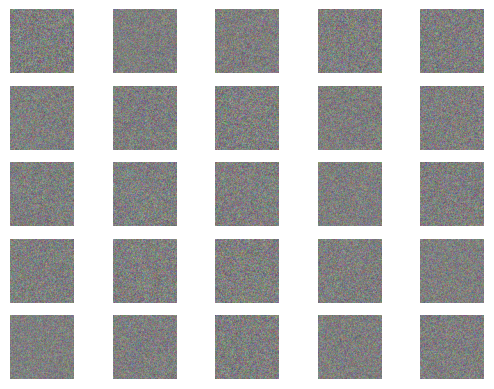

8/8 [==============================] - 0s 38ms/step
epoch: 32/100, disc_loss: 0.1342, gen_loss: 0.3127
8/8 [==============================] - 0s 37ms/step
epoch: 33/100, disc_loss: 0.1729, gen_loss: 0.3715
8/8 [==============================] - 0s 38ms/step
epoch: 34/100, disc_loss: 0.2003, gen_loss: 0.4327
8/8 [==============================] - 0s 37ms/step
epoch: 35/100, disc_loss: 0.2320, gen_loss: 0.4891
8/8 [==============================] - 0s 38ms/step
epoch: 36/100, disc_loss: 0.2449, gen_loss: 0.5363
8/8 [==============================] - 0s 37ms/step
epoch: 37/100, disc_loss: 0.2578, gen_loss: 0.5809
8/8 [==============================] - 0s 37ms/step
epoch: 38/100, disc_loss: 0.2973, gen_loss: 0.6129
8/8 [==============================] - 0s 37ms/step
epoch: 39/100, disc_loss: 0.3003, gen_loss: 0.6104
8/8 [==============================] - 0s 39ms/step
epoch: 40/100, disc_loss: 0.3059, gen_loss: 0.6463
8/8 [==============================] - 0s 37ms/step
epoch: 41/100, disc_l

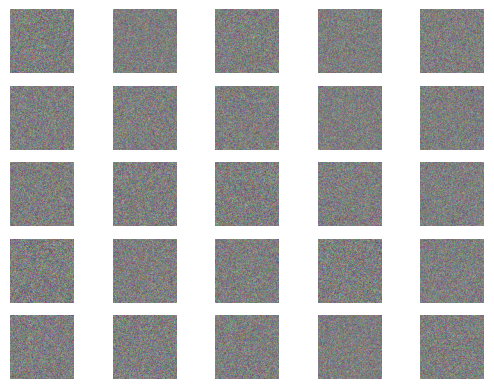

8/8 [==============================] - 0s 37ms/step
epoch: 42/100, disc_loss: 0.3255, gen_loss: 0.6668
8/8 [==============================] - 0s 37ms/step
epoch: 43/100, disc_loss: 0.3274, gen_loss: 0.6796
8/8 [==============================] - 0s 38ms/step
epoch: 44/100, disc_loss: 0.3105, gen_loss: 0.6717
8/8 [==============================] - 0s 38ms/step
epoch: 45/100, disc_loss: 0.3519, gen_loss: 0.6715
8/8 [==============================] - 0s 37ms/step
epoch: 46/100, disc_loss: 0.3317, gen_loss: 0.6629
8/8 [==============================] - 0s 38ms/step
epoch: 47/100, disc_loss: 0.3326, gen_loss: 0.6801
8/8 [==============================] - 0s 37ms/step
epoch: 48/100, disc_loss: 0.3335, gen_loss: 0.6609
8/8 [==============================] - 0s 38ms/step
epoch: 49/100, disc_loss: 0.3187, gen_loss: 0.6589
8/8 [==============================] - 0s 37ms/step
epoch: 50/100, disc_loss: 0.3208, gen_loss: 0.6621
8/8 [==============================] - 0s 38ms/step
epoch: 51/100, disc_l

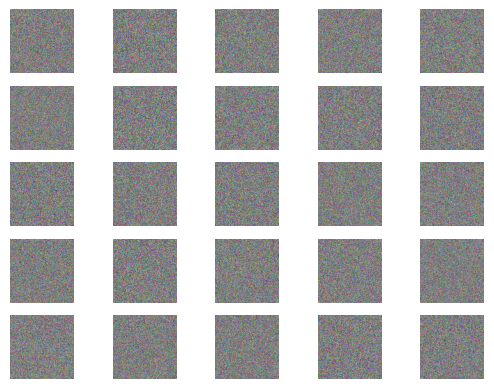

8/8 [==============================] - 0s 39ms/step
epoch: 52/100, disc_loss: 0.3242, gen_loss: 0.6814
8/8 [==============================] - 0s 38ms/step
epoch: 53/100, disc_loss: 0.3392, gen_loss: 0.6777
8/8 [==============================] - 0s 38ms/step
epoch: 54/100, disc_loss: 0.3333, gen_loss: 0.6831
8/8 [==============================] - 0s 46ms/step
epoch: 55/100, disc_loss: 0.3344, gen_loss: 0.6840
8/8 [==============================] - 0s 38ms/step
epoch: 56/100, disc_loss: 0.3411, gen_loss: 0.6921
8/8 [==============================] - 0s 38ms/step
epoch: 57/100, disc_loss: 0.3218, gen_loss: 0.6860
8/8 [==============================] - 0s 38ms/step
epoch: 58/100, disc_loss: 0.3220, gen_loss: 0.6785
8/8 [==============================] - 0s 37ms/step
epoch: 59/100, disc_loss: 0.3509, gen_loss: 0.7081
8/8 [==============================] - 0s 37ms/step
epoch: 60/100, disc_loss: 0.3470, gen_loss: 0.6714
8/8 [==============================] - 0s 37ms/step
epoch: 61/100, disc_l

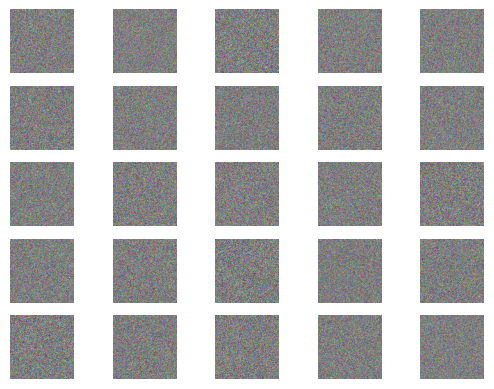

8/8 [==============================] - 0s 37ms/step
epoch: 62/100, disc_loss: 0.3558, gen_loss: 0.7080
8/8 [==============================] - 0s 38ms/step
epoch: 63/100, disc_loss: 0.3827, gen_loss: 0.7109
8/8 [==============================] - 0s 37ms/step
epoch: 64/100, disc_loss: 0.3478, gen_loss: 0.7281
8/8 [==============================] - 0s 38ms/step
epoch: 65/100, disc_loss: 0.3498, gen_loss: 0.7203
8/8 [==============================] - 0s 37ms/step
epoch: 66/100, disc_loss: 0.3478, gen_loss: 0.7064
8/8 [==============================] - 0s 38ms/step
epoch: 67/100, disc_loss: 0.3393, gen_loss: 0.7022
8/8 [==============================] - 0s 37ms/step
epoch: 68/100, disc_loss: 0.3729, gen_loss: 0.6969
8/8 [==============================] - 0s 38ms/step
epoch: 69/100, disc_loss: 0.3485, gen_loss: 0.7138
8/8 [==============================] - 0s 38ms/step
epoch: 70/100, disc_loss: 0.3349, gen_loss: 0.7133
8/8 [==============================] - 0s 38ms/step
epoch: 71/100, disc_l

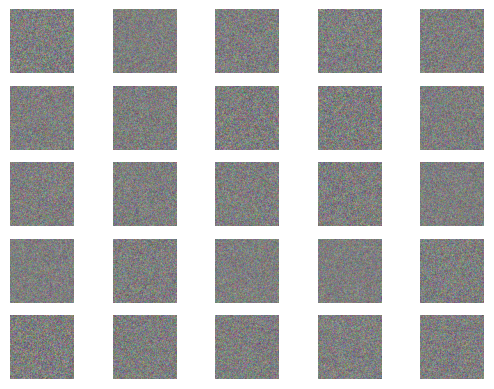

8/8 [==============================] - 0s 38ms/step
epoch: 72/100, disc_loss: 0.3488, gen_loss: 0.7283
8/8 [==============================] - 0s 38ms/step
epoch: 73/100, disc_loss: 0.3560, gen_loss: 0.6968
8/8 [==============================] - 0s 37ms/step
epoch: 74/100, disc_loss: 0.3497, gen_loss: 0.6961
8/8 [==============================] - 0s 37ms/step
epoch: 75/100, disc_loss: 0.3349, gen_loss: 0.6950
8/8 [==============================] - 0s 38ms/step
epoch: 76/100, disc_loss: 0.3255, gen_loss: 0.6852
8/8 [==============================] - 0s 38ms/step
epoch: 77/100, disc_loss: 0.3365, gen_loss: 0.6980
8/8 [==============================] - 0s 37ms/step
epoch: 78/100, disc_loss: 0.3459, gen_loss: 0.7147
8/8 [==============================] - 0s 37ms/step
epoch: 79/100, disc_loss: 0.3362, gen_loss: 0.7100
8/8 [==============================] - 0s 38ms/step
epoch: 80/100, disc_loss: 0.3464, gen_loss: 0.7087
8/8 [==============================] - 0s 36ms/step
epoch: 81/100, disc_l

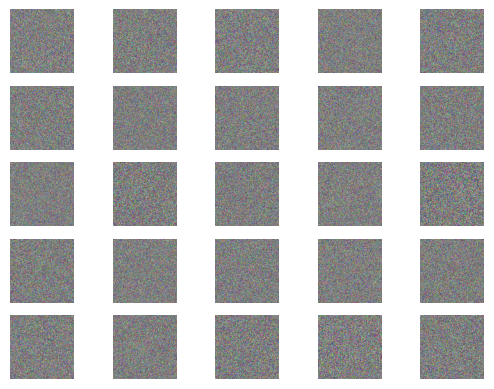

8/8 [==============================] - 0s 49ms/step
epoch: 82/100, disc_loss: 0.3336, gen_loss: 0.6898
8/8 [==============================] - 0s 39ms/step
epoch: 83/100, disc_loss: 0.3646, gen_loss: 0.6895
8/8 [==============================] - 0s 38ms/step
epoch: 84/100, disc_loss: 0.3378, gen_loss: 0.6780
8/8 [==============================] - 0s 42ms/step
epoch: 85/100, disc_loss: 0.3556, gen_loss: 0.6801
8/8 [==============================] - 0s 40ms/step
epoch: 86/100, disc_loss: 0.3378, gen_loss: 0.6782
8/8 [==============================] - 0s 37ms/step
epoch: 87/100, disc_loss: 0.3426, gen_loss: 0.6889
8/8 [==============================] - 0s 38ms/step
epoch: 88/100, disc_loss: 0.3479, gen_loss: 0.6747
8/8 [==============================] - 0s 37ms/step
epoch: 89/100, disc_loss: 0.3343, gen_loss: 0.6689
8/8 [==============================] - 0s 37ms/step
epoch: 90/100, disc_loss: 0.3402, gen_loss: 0.6759
8/8 [==============================] - 0s 38ms/step
epoch: 91/100, disc_l

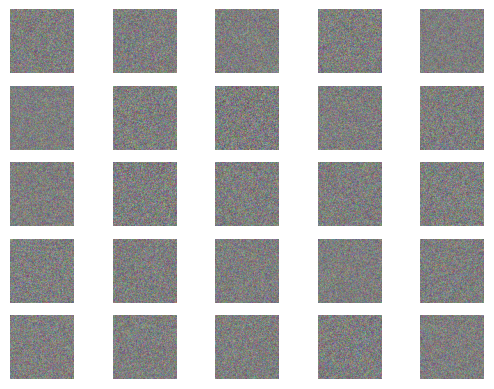

8/8 [==============================] - 0s 44ms/step
epoch: 92/100, disc_loss: 0.3318, gen_loss: 0.6607
8/8 [==============================] - 0s 37ms/step
epoch: 93/100, disc_loss: 0.3389, gen_loss: 0.6774
8/8 [==============================] - 0s 38ms/step
epoch: 94/100, disc_loss: 0.3090, gen_loss: 0.6685
8/8 [==============================] - 0s 38ms/step
epoch: 95/100, disc_loss: 0.3381, gen_loss: 0.6570
8/8 [==============================] - 0s 37ms/step
epoch: 96/100, disc_loss: 0.3298, gen_loss: 0.6658
8/8 [==============================] - 0s 38ms/step
epoch: 97/100, disc_loss: 0.3424, gen_loss: 0.6574
8/8 [==============================] - 0s 38ms/step
epoch: 98/100, disc_loss: 0.3383, gen_loss: 0.6908
8/8 [==============================] - 0s 37ms/step
epoch: 99/100, disc_loss: 0.3357, gen_loss: 0.6732
8/8 [==============================] - 0s 37ms/step
epoch: 100/100, disc_loss: 0.3242, gen_loss: 0.6775


In [27]:
#create losses
discriminator_loss = []
generator_loss = []

# training
for epoch in range(EPOCHS):
    #get batches of real images
    index = np.random.randint(0, train_images.shape[0], BATCH_SIZE) ###################################
    real_images = train_images[index]
    
    #get fake images
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    fake_images = generator.predict(noise)
    
    #train 
    disc_loss_real, disc_acc_real = discriminator.train_on_batch(real_images, ONES)
    disc_loss_fake, disc_acc_fake = discriminator.train_on_batch(fake_images, ZEROS)
    disc_loss = 0.5 * (disc_loss_real + disc_loss_fake)
    disc_acc = 0.5 * (disc_loss_real + disc_loss_fake)
    
    #train generator 
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    gen_loss = GAN.train_on_batch(noise, ONES)
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    gen_loss = GAN.train_on_batch(noise, ZEROS)
    
    #save loss
    discriminator_loss.append(disc_loss)
    generator_loss.append(gen_loss)
    
    print(f"epoch: {epoch+1}/{EPOCHS}, disc_loss: {disc_loss:.4f}, gen_loss: {gen_loss:.4f}")
    
    if epoch % 10 == 0:
        print(f'Fake Images at Epoch: {epoch+1}/{EPOCHS}')
        sample_images(epoch)

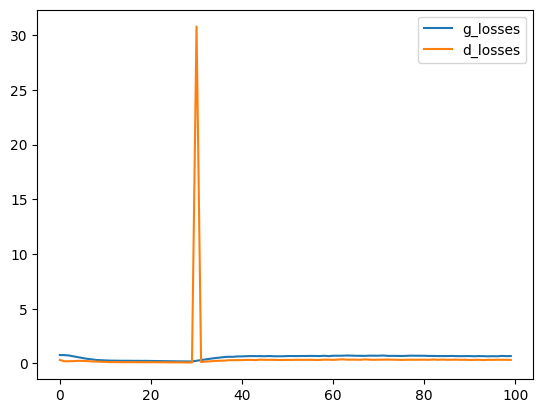

In [28]:
plt.plot(generator_loss, label='g_losses')
plt.plot(discriminator_loss, label='d_losses')
plt.legend();

### 4. Result


It looks like our model learned something! Great! Since we can't submit the project anymore (past competition dates), we can't see how well our model is performing so far. However, we can see that the model started to get more browns and started to form some sort of shape-like figures. However, it is obvious these are not dogs, or anything like it. As a first GAN project, I'm satisified that the model was able to run and start to learn something. After 200 epochs and many hours of waiting for the model to train, I've decided this is as far as I'll take it for this mini-project. We can see that the model was learning and (hopefully) improving. During this project, I tried modifying many parts of the model to try and get a better outcome such as different activation functions, different momentum values, different number of Convolutional layers, and different values of dropout. In all, since these models take so long to train, I tried 3 different combinations of values and structure and this was the best result thus far. In the conclusion, we'll discuss ways to improve the model.

In [29]:
#save images in zip
z = zipfile.PyZipFile('images.zip', mode='w')

#save model
model_filename = 'generator_model.h5'
tf.keras.models.save_model(generator, model_filename, overwrite=True, include_optimizer=True, save_format=None)

### 5. Conclusion
Our model did learn and begin to take shape. However, it is obvious our model did not create convincing dog images. There are a few suggestions: increase the number of epochs, modify the architecture and/or try transfer learning. Something that I would have liked to try was transfer learning during the generator part so that the model doesn't have to learn from 0. In addition, I think increasing the number of epochs would have useful. As we can see in the generated images, we are just now starting to get more "dog-like" colors and begining to create shapes. GANs are complex models which require much patience and knowledge. This project just scrapes the surface of GANs and how much they can accomplish.
